In [4]:
import sqlite3
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, accuracy

# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [5]:
values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0

    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue

    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])
    cena = float(row[16])

    row_x_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv]
    row_full_data = [distance, broj_soba, kvadratura, sprat, tip_gradnje, uknjizen, lift, garaza, terasa, pdv, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

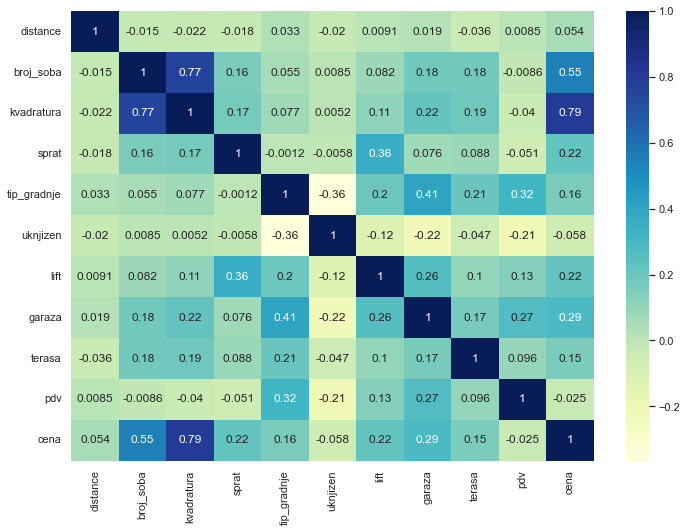

In [6]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv', 'cena']
df = pd.DataFrame(full_data, columns=header)
price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
categories = [0,1,2,3,4,5]
# corrM = df.corr()
# corrM
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [9]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df['cena']


# convert to numpy array
X = np.array(df_x)
y = np.array(y_data)
print(X.shape, y.shape)

# split into X_train and X_test
# always split into X_train, X_test first THEN apply minmax scaler
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# use minMax scaler
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

(11984, 10) (11984,)
(9587, 10) (2397, 10) (9587,) (2397,)


In [10]:
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              11000     
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 637,001
Trainable params: 637,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
192/192 [==============================] - 4s 14ms/step - loss: 48759345152.0000 - mae: 143732.9375 - val_loss: 23302576128.0000 - val_mae: 95355.5312
Epoch 2/5000
192/1

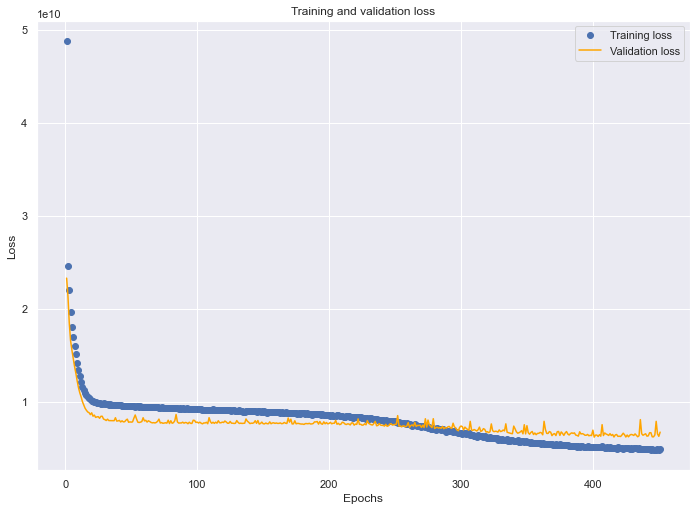

In [12]:
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

75/75 [==============================] - 0s 2ms/step


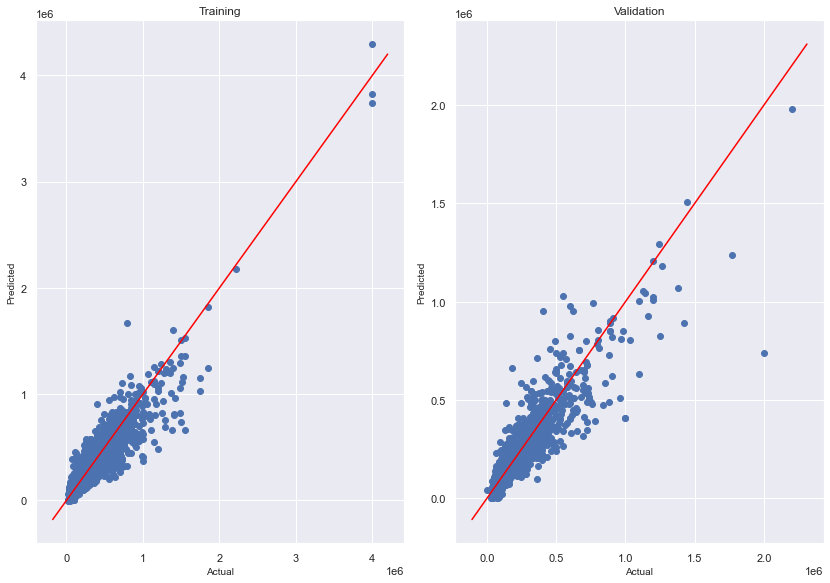

In [13]:
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [16]:
# metrics
pred = model.predict(X_test)
trainpreds = model.predict(X_train)
from sklearn.metrics import mean_absolute_error
print("mean_absolute_error on train data:" mean_absolute_error(y_train, trainpreds)) # train
print("mean_absolute_error on test data:"mean_absolute_error(y_test, pred)) # test

 1/75 [..............................] - ETA: 2s

300/300 [==============================] - 1s 2ms/step
42341.77075782334
46339.48797091754


Neuronska mreža za regresiju je prestala sa treniranjem nakon što nije pokazivala napredak u poslednjih 50 epoha. Zaustavila se u 451. epohi, a prosečna greška estimacije 46339 na test skupu. Ova vrednost je značajno bolja u poređenju sa Polinomijalnom regresijom koja je imala prosečnu grešku estimacije od 100908 evra. Ovaj rezultat je u skladu sa očekivanjima od neuronske mreže kao moćnog modela za regresiju.

In [71]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv']
df_x = pd.DataFrame(X_data, columns=header)

price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
categories = [0,1,2,3,4,5]
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'tip_gradnje', 'uknjizen', 'lift', 'garaza', 'terasa', 'pdv', 'cena']
df = pd.DataFrame(full_data, columns=header)
df['cena'] = pd.cut(df['cena'], bins=price_ranges, labels=categories)
y_data = df['cena']


# convert to numpy array
X = np.array(df_x)
y = np.array(y_data)

# split into X_train and X_test
# always split into X_train, X_test first THEN apply minmax scaler
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)

# use minMax scaler
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [90]:
model = Sequential()
model.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(6, activation='softmax')) # output node, 6 classes for classification
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights=True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 1000)              11000     
                                                                 
 dense_45 (Dense)            (None, 500)               500500    
                                                                 
 dense_46 (Dense)            (None, 500)               250500    
                                                                 
 dense_47 (Dense)            (None, 6)                 3006      
                                                                 
Total params: 765,006
Trainable params: 765,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
192/192 [==============================] - 6s 17ms/step - loss: 1.2454 - accuracy: 0.4683 - val_loss: 1.1135 - val_accuracy: 0.5398
Epoch 2/5000
192/192 [============

In [92]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
trainpreds = model.predict(X_train)
trainpreds = np.argmax(trainpreds, axis=1)
from sklearn.metrics import accuracy_score
print("accuracy_score train data: " + str(accuracy_score(y_train, trainpreds))) # train
print("accuracy_score test data: " + str(accuracy_score(y_test, pred)))

300/300 [==============================] - 1s 2ms/step
accuracy_score train data: 0.704182747470533
accuracy_score test data: 0.6599916562369629


In [84]:
print(np.min(pred))
print(pred)

0
[4 4 2 ... 4 2 4]


Neuronska mreža zaustavila se nakon 97 epoha jer nije pokazivala poboljšanje na funkciji gubitka na validacionom skupu. Njena tačnost ili preciznost iznosi 0.7569, što je neznatno bolje od tačnosti KNN modela koji iznosi 0.7501. Ovi rezultati ukazuju da postoji prostor za dalje poboljšanje neuronske mreže. 